In [1]:
import pandas as pd
import numpy as np
from math import sqrt, ceil
from timeit import timeit, Timer

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation

rc('text', usetex=False)
plt.style.use('seaborn')
%matplotlib inline

legend_opts = {
    'fontsize':12,
    'frameon':True, 
    'framealpha':1,
    'facecolor':'white',
    'edgecolor':'black',
    'labelspacing':0.1}
errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1
from utils import *

In [4]:
ci_multiplier = 2.262/np.sqrt(10)

# Load data

In [5]:
male_scores = pd.read_csv('scores/trimmed_male.csv')
female_scores = pd.read_csv('scores/trimmed_female.csv')

In [6]:
# Randomly choose 10 years for training set, and remaining 4 years for test set
# (which must include the last year 2018 for visualisation purpose)
all_years = range(2005, 2020)
years_before_last = range(2005, 2018)
year_seed = np.random.RandomState(seed=42)
train_years = sorted(list(year_seed.choice(years_before_last, size=10, replace=False)))
test_years = sorted([year for year in years_before_last if year not in train_years] + [2018, 2019])
train_years, test_years

([2005, 2006, 2007, 2009, 2010, 2012, 2013, 2014, 2016, 2017],
 [2008, 2011, 2015, 2018, 2019])

In [7]:
all_season_scores = male_scores.loc[male_scores['event']!='WR']
all_world_scores = male_scores.loc[male_scores['event']=='WR']

In [8]:
# Split 10 years into train and validation set
random_state = np.random.RandomState(seed=42)
years1 = list(random_state.choice(train_years, size=5, replace=False))
years2 = [year for year in train_years if year not in years1]
years1, years2

([2016, 2006, 2012, 2005, 2014], [2007, 2009, 2010, 2013, 2017])

# Predict ranking in training set from different methods

## Male

Beta for logistic regression model to combine multi-latent scores (obtained from part 5)

In [9]:
# Train on each 2-fold CV (5 years)
beta1 = np.load('data/male_beta1.npy')
beta2 = np.load('data/male_beta2.npy')

# Train on all 10 years in training set
beta_train = np.load('data/male_beta.npy')

### Skater scores

For each year calculate the difference in Kendall's tau from baseline for each year

In [10]:
all_skater_scores = {}
for year in train_years:
    yearly_skater_scores = []
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    
    # Season average scores
    avg = AverageScore()
    avg.fit(season_scores)
    yearly_skater_scores.append(avg.skater_scores.reindex(world_scores.index).dropna())
    
    # Additive latent score
    add = Linear()
    add.fit(season_scores)
    yearly_skater_scores.append(add.skater_scores.reindex(world_scores.index).dropna())

    # Multiplicative latent score
    mul = LogLinear()
    mul.fit(season_scores)
    yearly_skater_scores.append(mul.skater_scores.reindex(world_scores.index).dropna())
    
    # Single-factor hybrid-model latent score
    _, _, skater_scores = train_multi(season_scores, n_factors=1, alpha=0.0005, n_iter=47)
    skater_scores = skater_scores.squeeze().reindex(world_scores.index).dropna()
    yearly_skater_scores.append(skater_scores)
    
    # Multi-factor latent scores
    _, _, skater_scores = train_sequential_multi(season_scores, n_factors=4, alpha=0.0005, n_iter=35)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    # Normalize latent score before combining them using logistic regression
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    # Use different model coefficient for each fold
    if year in years1:
        combined_scores = normed_skater_scores @ beta2
    else:
        combined_scores = normed_skater_scores @ beta1
    yearly_skater_scores.append(combined_scores)
    
    # Combine all scores into dataframe, with index=skater, column=year
    yearly_skater_scores = pd.concat(yearly_skater_scores, axis=1)
    yearly_skater_scores.columns = ['avg', 'add', 'mul', 'hyb', 'multi']
    yearly_skater_scores = (yearly_skater_scores - yearly_skater_scores.mean(axis=0)) / yearly_skater_scores.std(axis=0)
    all_skater_scores[year] = yearly_skater_scores

Alpha: 0.0005, Iter: 46, Last RMSE: 8.63, Delta RMSE: -0.0010916085
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 8.662, Delta RMSE: -0.0080908948
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 8.605, Delta RMSE: -0.0024092949
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 8.519, Delta RMSE: -0.0036599525
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 8.518, Delta RMSE: -0.000746563
Alpha: 0.0005, Iter: 46, Last RMSE: 7.96, Delta RMSE: -0.0009913676
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 7.999, Delta RMSE: -0.007749829
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 7.986, Delta RMSE: -0.0006821397
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 7.957, Delta RMSE: -0.0011246966
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 7.931, Delta RMSE: -0.0010131301
Alpha: 0.0005, Iter: 46, Last RMSE: 7.62, Delta RMSE: -0.0015000168
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 7.679, Delta RMSE: -0.0133247831
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 7.67, Delta RMSE: -0.0005301796

# Borda count

In [13]:
# Get yearly Kendall's tau from average model for comparison
avg = AverageScore()
avg_result = avg.evaluate_over_years(all_years, all_season_scores, all_world_scores).set_index('year')
avg_taus = avg_result['tau'].to_dict()

In [14]:
def build_borda_score(season_scores, world_scores, skater_scores):
    world_ranking = list(world_scores.index)
    
    skater_scores = skater_scores.copy()
    # Find ranking from other skater scores (0=worse) and add them
    skater_scores['borda'] = skater_scores.values.argsort(axis=0).argsort(axis=0).sum(axis=1)
    # Sort skater rows by borda counts from lowes to highest, then average score for any ties in borda count
    skater_scores = skater_scores.sort_values(by=['borda', 'avg'])
    # Reset borda count to 0 to n_skater-1
    skater_scores['borda'] = range(len(skater_scores))

    # Reset rows back to world ranking order
    skater_scores = skater_scores.reindex(world_ranking).dropna()

    return skater_scores['borda']

In [15]:
dtaus_borda = {}
rankings_borda = {}

for year in train_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    skater_scores = all_skater_scores[year]
    borda_scores = build_borda_score(season_scores, world_scores, skater_scores)
    
    # 22 skaters, 21th skater -> 22 - 1 - 21 = 0th skater
    borda_ranking, world_ranking = return_ranking(borda_scores, world_scores)
    borda_tau = calculate_kendall_tau(borda_ranking, world_ranking)
    rankings_borda[year] = borda_ranking
    dtaus_borda[year] = borda_tau - avg_taus[year]

2005
There are 173 concordant_pairs out of 210 pairs
2006
There are 205 concordant_pairs out of 253 pairs
2007
There are 224 concordant_pairs out of 276 pairs
2009
There are 222 concordant_pairs out of 276 pairs
2010
There are 198 concordant_pairs out of 231 pairs
2012
There are 202 concordant_pairs out of 253 pairs
2013
There are 213 concordant_pairs out of 253 pairs
2014
There are 190 concordant_pairs out of 210 pairs
2016
There are 233 concordant_pairs out of 276 pairs
2017
There are 240 concordant_pairs out of 276 pairs


In [16]:
np.mean(list(dtaus_borda.values()))

0.0026708074534161574

In [17]:
np.std(list(dtaus_borda.values())) * ci_multiplier

0.026224239759557007

# Logistic regression

## Score difference

In [18]:
X1 = {}
X2 = {}
for year, skater_scores in all_skater_scores.items():
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores.values, 2)))
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X
        
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

In [19]:
log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)
log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)

avg_dtaus_train = []
avg_dtaus_val = []
std_dtaus_val = []
log_iters = []
gammas1 = []
gammas2 = []

# Train logistic regression model on each fold and return logged values at specified iterations
for log_log1, log_log2 in zip(log_gen1, log_gen2):
    log_iter = log_log1[0]
    gamma1 = log_log1[1]
    gamma2 = log_log2[1]
    
    gammas1.append(gamma1)
    gammas2.append(gamma2)

    # Model coefficients at specified iterations are used to evaluate
    # improvement in Kendall's tau on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], gamma1) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], gamma2) - avg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], gamma2) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], gamma1) - avg_taus[year]

    # Take average improvement in Kendall's tau for each combination of
    # stopping iterations of multi-factor and logistic regression model
    log_iters.append(log_iter)
    avg_dtaus_train.append(np.mean(list(dtaus_train.values())))
    avg_dtaus_val.append(np.mean(list(dtaus_val.values())))
    std_dtaus_val.append(np.std(list(dtaus_val.values())))

Alpha: 0.0005, Iter: 1999, Last LL: -0.34, Delta LL: 8e-08


In [20]:
max_val_iter_log = np.argmax(avg_dtaus_val)
max_val_iter_log

133

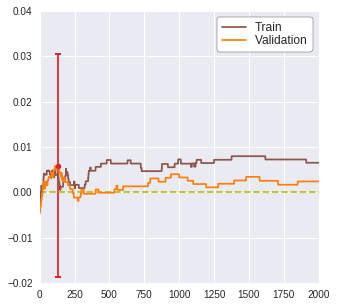

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='tab:olive', ls='--')
ax.plot(avg_dtaus_train, color='tab:brown', label='Train')
ax.plot(avg_dtaus_val, color='tab:orange', label='Validation')
ax.errorbar(max_val_iter_log, avg_dtaus_val[max_val_iter_log], ci_multiplier*std_dtaus_val[max_val_iter_log], color='tab:red', fmt='.-', **errorbar_opts)
ax.legend(**legend_opts)
ax.set_xlim(0, 2000)
ax.set_ylim(-0.02, 0.04)

plt.show()
fig.savefig('viz/male_log_ensemble_cv.png')

In [22]:
gamma1_max = gammas1[max_val_iter_log]
gamma2_max = gammas2[max_val_iter_log]
X_train = np.vstack([stacked_X1, stacked_X2])
gamma_train = log_gradient_ascent(X_train, alpha=0.0005, n_iter=max_val_iter_log+1)
gamma_train

Alpha: 0.0005, Iter: 133, Last LL: -0.36, Delta LL: 6.7582e-06


array([ 0.67068831,  0.21136784, -0.27231644,  0.45196117,  0.91410564])

### Plot all rankings for 2017 male skaters

In [23]:
def get_rankings_from_score_matrix(score_matrix):
    '''
    Convert a pandas DataFrame of latent scores (from different models)
    into list of predicted rankings (names of skaters from highest to lowest ranks), one for each model
    '''
    # Get index of skater if score for each column was sorted from lowest to highest
    rankings = score_matrix.values.argsort(axis=0)
    # Reverse sort ranking (index of highest rank appears first)
    # Transpose to allow for index slicing
    rankings = rankings[::-1, :].T
    return score_matrix.index[rankings].tolist()

In [24]:
season_scores, world_scores = get_yearly_scores(2017, all_season_scores, all_world_scores)
world_ranking = list(world_scores.index)
all_rankings = get_rankings_from_score_matrix(all_skater_scores[2017])
borda_ranking = rankings_borda[2017]
log_ranking = list((all_skater_scores[2017] @ gamma1_max).sort_values(ascending=False).index)
all_rankings.append(borda_ranking)
all_rankings.append(log_ranking)
all_rankings.append(world_ranking)

In [25]:
labels=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 'Borda', 'Logistic', 'World']
labels = [f'{label}\n{calculate_kendall_tau(ranking, world_ranking, return_pairs=True)[1]}' for label, ranking in zip(labels, all_rankings)]

There are 234 concordant_pairs out of 276 pairs
There are 239 concordant_pairs out of 276 pairs
There are 239 concordant_pairs out of 276 pairs
There are 241 concordant_pairs out of 276 pairs
There are 242 concordant_pairs out of 276 pairs
There are 240 concordant_pairs out of 276 pairs
There are 243 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs


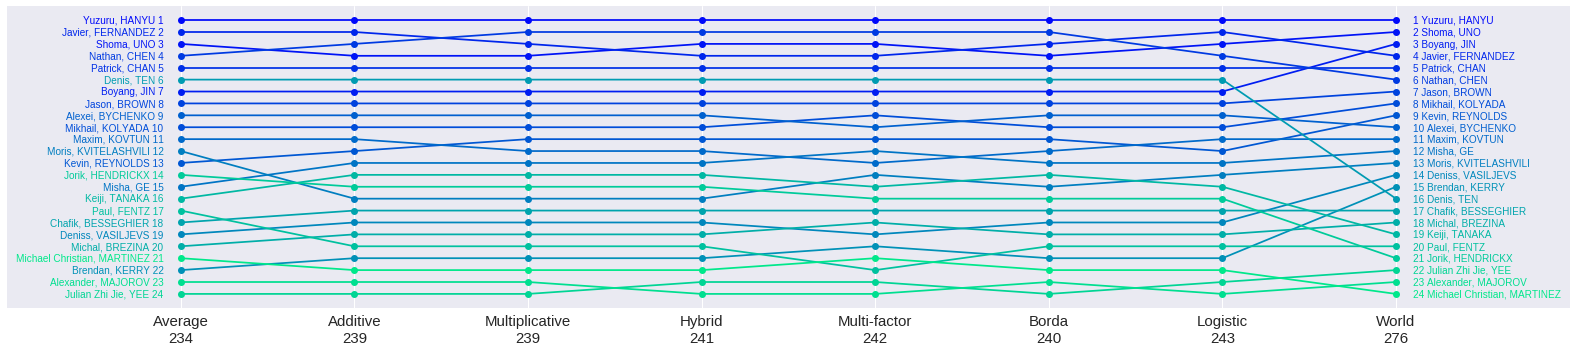

In [26]:
fig, ax = plt.subplots(figsize=(22, 5))
plot_multiple_rankings(fig, ax, all_rankings, labels=labels,
                       filepath='viz/2017_male_2017_all_models.png', xfontsize=15)

## Rank difference

In [27]:
X1 = {}
X2 = {}
for year, skater_scores in all_skater_scores.items():
    skater_ranks = skater_scores.values.argsort(axis=0).argsort(axis=0)
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_ranks, 2)))
    if year in years1:
        X1[year] = X
    else:
        X2[year] = X
        
stacked_X1 = np.concatenate(list(X1.values()))
stacked_X2 = np.concatenate(list(X2.values()))

In [28]:
log_gen1 = log_gradient_ascent_log(stacked_X1, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)
log_gen2 = log_gradient_ascent_log(stacked_X2, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)

avg_dtaus_train = []
avg_dtaus_val = []
log_iters = []

# Train logistic regression model on each fold and return logged values at specified iterations
for log_log1, log_log2 in zip(log_gen1, log_gen2):
    log_iter = log_log1[0]
    beta1 = log_log1[1]
    beta2 = log_log2[1]

    # Model coefficients at specified iterations are used to evaluate
    # improvement in Kendall's tau on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], beta1) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], beta2) - avg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], beta2) - avg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], beta1) - avg_taus[year]

    # Take average improvement in Kendall's tau for each combination of
    # stopping iterations of multi-factor and logistic regression model
    log_iters.append(log_iter)
    avg_dtaus_train.append(np.mean(list(dtaus_train.values())))
    avg_dtaus_val.append(np.mean(list(dtaus_val.values())))

Alpha: 0.0005, Iter: 1999, Last LL: -2.79, Delta LL: 1.2266428713


For some reason very unstable performance

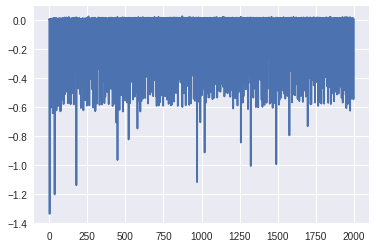

In [29]:
plt.plot(avg_dtaus_train)
# plt.plot(avg_dtaus_val)
# plt.xlim(0, 1000)

# Benchmark for test

### Previous 5 scores

In [30]:
all_test_skater_scores = {}
for year in test_years:
    yearly_skater_scores = []
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)

    avg = AverageScore()
    avg.fit(season_scores)
    yearly_skater_scores.append(avg.skater_scores.reindex(world_scores.index).dropna())

    add = Linear()
    add.fit(season_scores)
    yearly_skater_scores.append(add.skater_scores.reindex(world_scores.index).dropna())

    mul = LogLinear()
    mul.fit(season_scores)
    yearly_skater_scores.append(mul.skater_scores.reindex(world_scores.index).dropna())

    _, _, skater_scores = train_multi(season_scores, n_factors=1, alpha=0.0005, n_iter=47)
    skater_scores = skater_scores.squeeze().reindex(world_scores.index).dropna()
    yearly_skater_scores.append(skater_scores)

    _, _, skater_scores = train_sequential_multi(season_scores, n_factors=4, alpha=0.0005, n_iter=35)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    combined_scores = normed_skater_scores @ beta_train
    yearly_skater_scores.append(combined_scores)
    
    yearly_skater_scores = pd.concat(yearly_skater_scores, axis=1)
    yearly_skater_scores.columns = ['avg', 'add', 'mul', 'hyb', 'multi']
    yearly_skater_scores = (yearly_skater_scores - yearly_skater_scores.mean(axis=0)) / yearly_skater_scores.std(axis=0)
    all_test_skater_scores[year] = yearly_skater_scores

Alpha: 0.0005, Iter: 46, Last RMSE: 7.39, Delta RMSE: -0.0022676327
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 7.451, Delta RMSE: -0.0127024616
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 7.423, Delta RMSE: -0.0009701527
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 7.415, Delta RMSE: -0.0008641666
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 7.395, Delta RMSE: -0.0009188739
Alpha: 0.0005, Iter: 46, Last RMSE: 6.22, Delta RMSE: -0.0003275182
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 6.23, Delta RMSE: -0.0045558128
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 6.219, Delta RMSE: -0.0004343555
Factor: 2, Alpha: 0.0005, Iter: 35, Last RMSE: 6.211, Delta RMSE: -0.0005299526
Factor: 3, Alpha: 0.0005, Iter: 35, Last RMSE: 6.209, Delta RMSE: -0.0002855435
Alpha: 0.0005, Iter: 46, Last RMSE: 10.78, Delta RMSE: -0.0003075517
Factor: 0, Alpha: 0.0005, Iter: 35, Last RMSE: 10.787, Delta RMSE: -0.0030421871
Factor: 1, Alpha: 0.0005, Iter: 35, Last RMSE: 10.741, Delta RMSE: -0.00245

In [31]:
dtaus_test = {}
for year in test_years:
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    skater_scores = all_test_skater_scores[year]
    dtaus = {}
    for col_name, col in skater_scores.iteritems():
        predicted_ranking, world_ranking = return_ranking(col, world_scores)
        tau = calculate_kendall_tau(predicted_ranking, world_ranking, verbose=False)
        dtaus[col_name] = tau - avg_taus[year]
    dtaus_test[year] = dtaus      

In [32]:
previous_results = pd.DataFrame(dtaus_test).reindex(['avg', 'add', 'mul', 'hyb', 'multi'])
previous_dtau_avgs, previous_dtau_stds = list(previous_results.mean(axis=1)), list(previous_results.std(axis=1))

### Borda

In [33]:
test_dtaus_borda = {}
test_rankings_borda = {}

for year in test_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, all_season_scores, all_world_scores)
    skater_scores = all_test_skater_scores[year]
    borda_scores = build_borda_score(season_scores, world_scores, skater_scores)
    
    # 22 skaters, 21th skater -> 22 - 1 - 21 = 0th skater
    borda_ranking, world_ranking = return_ranking(borda_scores, world_scores)
    borda_tau = calculate_kendall_tau(borda_ranking, world_ranking)
    test_rankings_borda[year] = borda_ranking
    test_dtaus_borda[year] = borda_tau - avg_taus[year]

2008
There are 190 concordant_pairs out of 231 pairs
2011
There are 187 concordant_pairs out of 231 pairs
2015
There are 222 concordant_pairs out of 276 pairs
2018
There are 215 concordant_pairs out of 276 pairs
2019
There are 220 concordant_pairs out of 276 pairs


In [34]:
borda_dtau_avg, borda_dtau_std = np.mean(list(test_dtaus_borda.values())), np.std(list(test_dtaus_borda.values()))

### Logistic

In [35]:
X_test = {}
for year, skater_scores in all_test_skater_scores.items():
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores.values, 2)))
    X_test[year] = X

In [36]:
test_dtaus_log = {}
for year in test_years:
    test_dtaus_log[year] = (get_tau_from_X_beta(X_test[year], gamma_train) - avg_taus[year])

log_dtau_avg, log_dtau_std = np.mean(list(test_dtaus_log.values())), np.std(list(test_dtaus_log.values()))

### Plot

In [43]:
all_dtau_avgs = np.array(previous_dtau_avgs + [borda_dtau_avg] + [log_dtau_avg])
all_dtau_stds = np.array(previous_dtau_stds + [borda_dtau_std] + [log_dtau_std])

In [44]:
season_scores, world_scores = get_yearly_scores(2019, all_season_scores, all_world_scores)
world_ranking = list(world_scores.index)
predicted_rankings = get_rankings_from_score_matrix(all_test_skater_scores[2019])
predicted_rankings.append(test_rankings_borda[2019])
predicted_rankings.append(list((all_test_skater_scores[2019] @ gamma_train).sort_values(ascending=False).index))

There are 216 concordant_pairs out of 276 pairs
There are 219 concordant_pairs out of 276 pairs
There are 220 concordant_pairs out of 276 pairs
There are 219 concordant_pairs out of 276 pairs
There are 219 concordant_pairs out of 276 pairs
There are 220 concordant_pairs out of 276 pairs
There are 220 concordant_pairs out of 276 pairs
There are 276 concordant_pairs out of 276 pairs


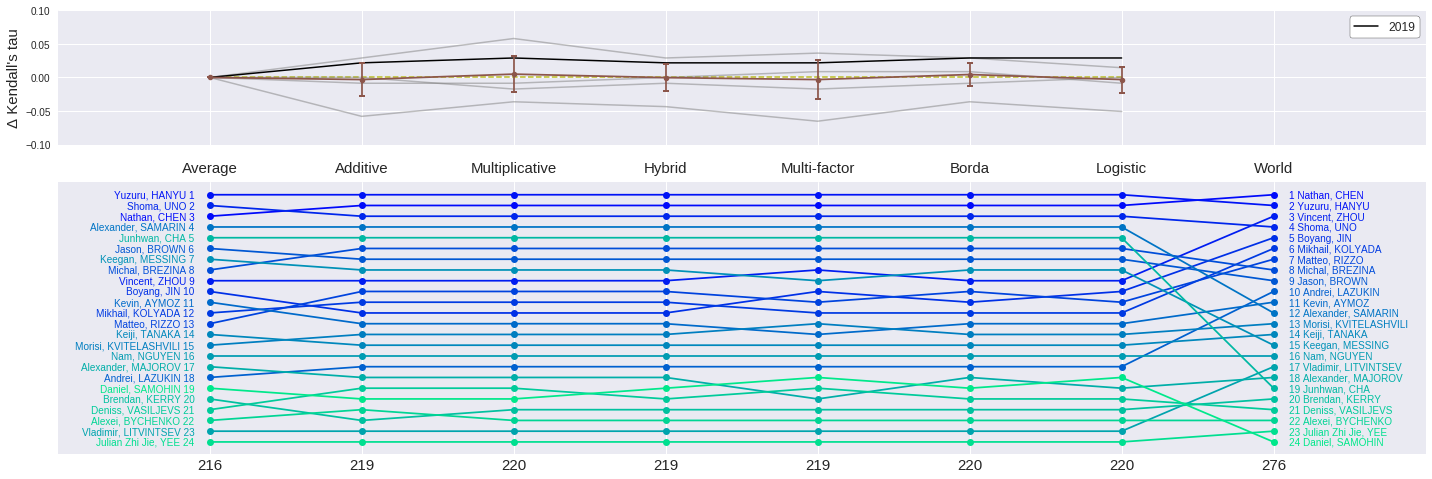

In [80]:
fig = plt.figure(figsize=(20, 7))
grid = plt.GridSpec(15, 1)
ax2 = fig.add_subplot(grid[5:14, :])
ax1 = fig.add_subplot(grid[0:5, :], sharex=ax2)

errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}

# Plot concordant pairs and Kendall's tau against lambda
ax1.errorbar(range(len(all_dtau_avgs)), all_dtau_avgs, yerr=ci_multiplier*all_dtau_stds,
           fmt='.-', color='tab:brown', zorder=10, **errorbar_opts)

for year in test_years:
    previous_dtaus = list(previous_results[year])
    borda_dtau = test_dtaus_borda[year]
    log_dtau = test_dtaus_log[year]
    yearly_dtau = previous_dtaus + [borda_dtau] + [log_dtau]
    if year == 2019:
        color, alpha, label = 'black', 1, '2019'
    else:
        color, alpha, label = 'tab:gray', 0.5, '_nolegend_'
    ax1.plot(range(len(yearly_dtau)), yearly_dtau, lw=1.5, color=color, alpha=alpha, label=label)
    
ax1.hlines(0, xmin=0, xmax=len(yearly_dtau)-1, color='tab:olive', lw=1.5, linestyles='--')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend(**legend_opts)
ax1.set_ylabel("Δ Kendall's tau", fontsize=15)
ax1.set_ylim(-0.1, 0.1)

world_ranking = all_test_skater_scores[2019].index
plot_multiple_rankings(fig, ax2, predicted_rankings + [world_ranking], labels=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 'Borda', 'Logistic', 'World'],
                       filepath=None, xfontsize=15)
for i, ranking in enumerate(predicted_rankings + [world_ranking]):
    _, n_concordant, _ = calculate_kendall_tau(ranking, world_ranking, return_pairs=True)
    ax2.text(i, -2.5, s=n_concordant, ha='center', fontsize=15)
ax2.xaxis.tick_top()

plt.tight_layout()
fig.savefig('viz/male_test.png', bbox_tight=True)

In [48]:
male_test_results = pd.DataFrame({'avg': all_dtau_avgs, 'std': all_dtau_stds}, index=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 'Borda', 'Logistic'])
male_test_results

,avg,std
Average,0.000000,0.000000
Additive,-0.003181,0.034270
Multiplicative,0.004950,0.037967
Hybrid,-0.000282,0.028625
Multi-factor,-0.003181,0.039884
Borda,0.004348,0.024692
Logistic,-0.003181,0.027009


In [49]:
male_test_results.to_csv('viz/male_dtau_test.csv')

# Do the same for female skaters

In [52]:
fall_season_scores = female_scores.loc[female_scores['event']!='WR']
fall_world_scores = female_scores.loc[female_scores['event']=='WR']

In [53]:
fbeta1 = np.load('data/female_beta1.npy')
fbeta2 = np.load('data/female_beta2.npy')
fbeta_train = np.load('data/female_beta.npy')

## Logistic

In [54]:
fall_train_skater_scores = {}
for year in train_years:
    yearly_skater_scores = []
    season_scores, world_scores = get_yearly_scores(year, fall_season_scores, fall_world_scores)

    avg = AverageScore()
    avg.fit(season_scores)
    yearly_skater_scores.append(avg.skater_scores.reindex(world_scores.index).dropna())

    add = Linear()
    add.fit(season_scores)
    yearly_skater_scores.append(add.skater_scores.reindex(world_scores.index).dropna())

    mul = LogLinear()
    mul.fit(season_scores)
    yearly_skater_scores.append(mul.skater_scores.reindex(world_scores.index).dropna())

    _, _, skater_scores = train_multi(season_scores, n_factors=1, alpha=0.0005, n_iter=41)
    skater_scores = skater_scores.squeeze().reindex(world_scores.index).dropna()
    yearly_skater_scores.append(skater_scores)

    _, _, skater_scores = train_sequential_multi(season_scores, n_factors=2, alpha=0.0005, n_iter=65)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    if year in years1:
        combined_scores = normed_skater_scores @ fbeta2
    else:
        combined_scores = normed_skater_scores @ fbeta1
    yearly_skater_scores.append(combined_scores)
    
    yearly_skater_scores = pd.concat(yearly_skater_scores, axis=1)
    yearly_skater_scores.columns = ['avg', 'add', 'mul', 'hyb', 'multi']
    yearly_skater_scores = (yearly_skater_scores - yearly_skater_scores.mean(axis=0)) / yearly_skater_scores.std(axis=0)
    fall_train_skater_scores[year] = yearly_skater_scores

Alpha: 0.0005, Iter: 40, Last RMSE: 6.39, Delta RMSE: -0.0120664969
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.3, Delta RMSE: -0.0009581742
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.269, Delta RMSE: -0.0009046723
Alpha: 0.0005, Iter: 40, Last RMSE: 6.71, Delta RMSE: -0.0079552953
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.646, Delta RMSE: -0.0012421858
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.528, Delta RMSE: -0.0046370313
Alpha: 0.0005, Iter: 40, Last RMSE: 6.49, Delta RMSE: -0.0113586593
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.39, Delta RMSE: -0.0009371606
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.383, Delta RMSE: -0.0001996698
Alpha: 0.0005, Iter: 40, Last RMSE: 5.51, Delta RMSE: -0.0098433761
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 5.453, Delta RMSE: -0.0002771063
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 5.437, Delta RMSE: -0.0002842119
Alpha: 0.0005, Iter: 40, Last RMSE: 6.77, Delta RMSE: -0.0073108777
Factor: 0, Alpha: 0.000

In [55]:
# Get yearly Kendall's tau from average model for comparison
favg = AverageScore()
favg_result = avg.evaluate_over_years(all_years, fall_season_scores, fall_world_scores).set_index('year')
favg_taus = favg_result['tau'].to_dict()

In [56]:
fX1 = {}
fX2 = {}
for year, skater_scores in fall_train_skater_scores.items():
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores.values, 2)))
    if year in years1:
        fX1[year] = X
    else:
        fX2[year] = X
        
fstacked_X1 = np.concatenate(list(fX1.values()))
fstacked_X2 = np.concatenate(list(fX2.values()))

In [57]:
flog_gen1 = log_gradient_ascent_log(stacked_X1, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)
flog_gen2 = log_gradient_ascent_log(stacked_X2, alpha=0.0005, n_iter=2000, log_every=1, verbose=True)

favg_dtaus_train = []
favg_dtaus_val = []
fstd_dtaus_val = []
fdtaus_val = []
flog_iters = []
fgammas1 = []
fgammas2 = []

# Train logistic regression model on each fold and return logged values at specified iterations
for log_log1, log_log2 in zip(flog_gen1, flog_gen2):
    log_iter = log_log1[0]
    gamma1 = log_log1[1]
    gamma2 = log_log2[1]
    
    fgammas1.append(gamma1)
    fgammas2.append(gamma2)

    # Model coefficients at specified iterations are used to evaluate
    # improvement in Kendall's tau on both folds
    dtaus_train = {}
    dtaus_val = {}
    for year in years1:
        dtaus_train[year] = get_tau_from_X_beta(X1[year], gamma1) - favg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X1[year], gamma2) - favg_taus[year]
    for year in years2:
        dtaus_train[year] = get_tau_from_X_beta(X2[year], gamma2) - favg_taus[year]
        dtaus_val[year] = get_tau_from_X_beta(X2[year], gamma1) - favg_taus[year]

    # Take average improvement in Kendall's tau for each combination of
    # stopping iterations of multi-factor and logistic regression model
    flog_iters.append(log_iter)
    favg_dtaus_train.append(np.mean(list(dtaus_train.values())))
    fdtaus_val.append(dtaus_val)
    favg_dtaus_val.append(np.mean(list(dtaus_val.values())))
    fstd_dtaus_val.append(np.std(list(dtaus_val.values())))

Alpha: 0.0005, Iter: 1999, Last LL: -2.79, Delta LL: 1.2266428713


In [58]:
fmax_val_iter_log = np.argmax(favg_dtaus_val)
fmax_val_iter_log

57

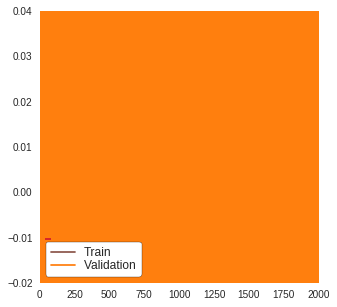

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(0, color='tab:olive', ls='--')
ax.plot(favg_dtaus_train, color='tab:brown', label='Train')
ax.plot(favg_dtaus_val, color='tab:orange', label='Validation')
ax.errorbar(fmax_val_iter_log, favg_dtaus_val[fmax_val_iter_log], ci_multiplier*fstd_dtaus_val[fmax_val_iter_log], color='tab:red', fmt='.-', **errorbar_opts)
ax.legend(**legend_opts)
ax.set_xlim(0, 2000)
ax.set_ylim(-0.02, 0.04)

plt.show()
fig.savefig('viz/log_ensemble_cv.png')

In [60]:
fgamma1_max = gammas1[fmax_val_iter_log]
fgamma2_max = gammas2[fmax_val_iter_log]
fX_train = np.vstack([stacked_X1, stacked_X2])
fgamma_train = log_gradient_ascent(X_train, alpha=0.0005, n_iter=fmax_val_iter_log+1)

Alpha: 0.0005, Iter: 57, Last LL: -0.36, Delta LL: 2.11816e-05


In [61]:
fgamma_train

array([ 0.5951356 ,  0.36052945, -0.18867325,  0.47750578,  0.72389823])

## Test

### Previous scores

In [62]:
fall_season_scores = female_scores.loc[female_scores['event']!='WR']
fall_world_scores = female_scores.loc[female_scores['event']=='WR']

In [63]:
fall_test_skater_scores = {}
for year in test_years:
    print(year)
    yearly_skater_scores = []
    season_scores, world_scores = get_yearly_scores(year, fall_season_scores, fall_world_scores)

    avg = AverageScore()
    avg.fit(season_scores)
    yearly_skater_scores.append(avg.skater_scores.reindex(world_scores.index).dropna())

    add = Linear()
    add.fit(season_scores)
    yearly_skater_scores.append(add.skater_scores.reindex(world_scores.index).dropna())

    mul = LogLinear()
    mul.fit(season_scores)
    yearly_skater_scores.append(mul.skater_scores.reindex(world_scores.index).dropna())

    _, _, skater_scores = train_multi(season_scores, n_factors=1, alpha=0.0005, n_iter=41)
    skater_scores = skater_scores.squeeze().reindex(world_scores.index).dropna()
    yearly_skater_scores.append(skater_scores)

    _, _, skater_scores = train_sequential_multi(season_scores, n_factors=2, alpha=0.0005, n_iter=65)
    skater_scores = skater_scores.reindex(world_scores.index).dropna()
    normed_skater_scores = (skater_scores - skater_scores.mean(axis=0)) / skater_scores.std(axis=0)
    combined_scores = normed_skater_scores @ fbeta_train
    yearly_skater_scores.append(combined_scores)
    
    yearly_skater_scores = pd.concat(yearly_skater_scores, axis=1)
    yearly_skater_scores.columns = ['avg', 'add', 'mul', 'hyb', 'multi']
    yearly_skater_scores = (yearly_skater_scores - yearly_skater_scores.mean(axis=0)) / yearly_skater_scores.std(axis=0)
    fall_test_skater_scores[year] = yearly_skater_scores

2008
Alpha: 0.0005, Iter: 40, Last RMSE: 5.63, Delta RMSE: -0.0108562991
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 5.553, Delta RMSE: -0.0003430157
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 5.514, Delta RMSE: -0.0011726186
2011
Alpha: 0.0005, Iter: 40, Last RMSE: 7.87, Delta RMSE: -0.0122482669
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 7.774, Delta RMSE: -0.0008415825
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 7.61, Delta RMSE: -0.007464855
2015
Alpha: 0.0005, Iter: 40, Last RMSE: 6.14, Delta RMSE: -0.0082668638
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.093, Delta RMSE: -0.0002471741
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.076, Delta RMSE: -0.0004583345
2018
Alpha: 0.0005, Iter: 40, Last RMSE: 7.02, Delta RMSE: -0.0039093538
Factor: 0, Alpha: 0.0005, Iter: 65, Last RMSE: 6.997, Delta RMSE: -0.0001944147
Factor: 1, Alpha: 0.0005, Iter: 65, Last RMSE: 6.919, Delta RMSE: -0.0028749849
2019
Alpha: 0.0005, Iter: 40, Last RMSE: 6.5, Delta RMSE: -0.005879790

In [64]:
fdtaus_test = {}
for year in test_years:
    season_scores, world_scores = get_yearly_scores(year, fall_season_scores, fall_world_scores)
    skater_scores = fall_test_skater_scores[year]
    dtaus = {}
    for col_name, col in skater_scores.iteritems():
        predicted_ranking, world_ranking = return_ranking(col, world_scores)
        tau = calculate_kendall_tau(predicted_ranking, world_ranking, verbose=False)
        dtaus[col_name] = tau - favg_taus[year]
    fdtaus_test[year] = dtaus      

In [65]:
fprevious_results = pd.DataFrame(fdtaus_test).reindex(['avg', 'add', 'mul', 'hyb', 'multi'])
fprevious_dtau_avgs, fprevious_dtau_stds = list(fprevious_results.mean(axis=1)), list(fprevious_results.std(axis=1))

### Borda

In [66]:
ftest_dtaus_borda = {}
ftest_rankings_borda = {}

for year in test_years:
    print(year)
    season_scores, world_scores = get_yearly_scores(year, fall_season_scores, fall_world_scores)
    skater_scores = fall_test_skater_scores[year]
    borda_scores = build_borda_score(season_scores, world_scores, skater_scores)
    
    # 22 skaters, 21th skater -> 22 - 1 - 21 = 0th skater
    borda_ranking, world_ranking = return_ranking(borda_scores, world_scores)
    borda_tau = calculate_kendall_tau(borda_ranking, world_ranking)
    ftest_rankings_borda[year] = borda_ranking
    ftest_dtaus_borda[year] = borda_tau - favg_taus[year]

2008
There are 208 concordant_pairs out of 253 pairs
2011
There are 190 concordant_pairs out of 231 pairs
2015
There are 193 concordant_pairs out of 231 pairs
2018
There are 199 concordant_pairs out of 231 pairs
2019
There are 197 concordant_pairs out of 231 pairs


In [67]:
fborda_dtau_avg, fborda_dtau_std = np.mean(list(ftest_dtaus_borda.values())), np.std(list(ftest_dtaus_borda.values()))

### Logistic

In [68]:
fX_test = {}
for year, skater_scores in fall_test_skater_scores.items():
    X = np.array(list(skater1 - skater2 for skater1, skater2 in combinations(skater_scores.values, 2)))
    fX_test[year] = X

In [69]:
ftest_dtaus_log = {}
for year in test_years:
    ftest_dtaus_log[year] = (get_tau_from_X_beta(fX_test[year], fgamma_train) - favg_taus[year])

flog_dtau_avg, flog_dtau_std = np.mean(list(test_dtaus_log.values())), np.std(list(test_dtaus_log.values()))

### Plot

In [70]:
fall_dtau_avgs = np.array(fprevious_dtau_avgs + [fborda_dtau_avg] + [flog_dtau_avg])
fall_dtau_stds = np.array(fprevious_dtau_stds + [fborda_dtau_std] + [flog_dtau_std])

In [71]:
season_scores, world_scores = get_yearly_scores(2019, fall_season_scores, fall_world_scores)
world_ranking = list(world_scores.index)
fpredicted_rankings = get_rankings_from_score_matrix(fall_test_skater_scores[2019])
fpredicted_rankings.append(ftest_rankings_borda[2019])
fpredicted_rankings.append(list((fall_test_skater_scores[2019] @ fgamma_train).sort_values(ascending=False).index))

There are 197 concordant_pairs out of 231 pairs
There are 194 concordant_pairs out of 231 pairs
There are 197 concordant_pairs out of 231 pairs
There are 196 concordant_pairs out of 231 pairs
There are 196 concordant_pairs out of 231 pairs
There are 197 concordant_pairs out of 231 pairs
There are 192 concordant_pairs out of 231 pairs
There are 231 concordant_pairs out of 231 pairs


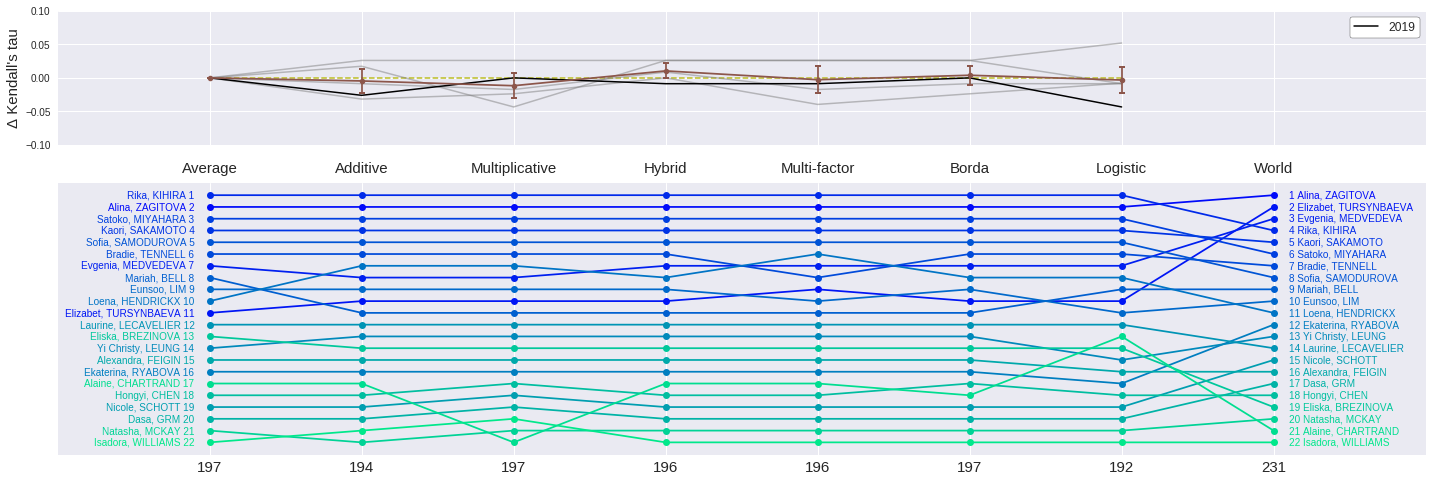

In [76]:
fig = plt.figure(figsize=(20, 7))
grid = plt.GridSpec(15, 1)
ax2 = fig.add_subplot(grid[5:14, :])
ax1 = fig.add_subplot(grid[0:5, :], sharex=ax2)

errorbar_opts = {'markeredgewidth': 2, 'capsize': 3}

# Plot concordant pairs and Kendall's tau against lambda
ax1.errorbar(range(len(fall_dtau_avgs)), fall_dtau_avgs, yerr=ci_multiplier*fall_dtau_stds,
           fmt='.-', color='tab:brown', zorder=10, **errorbar_opts)

for year in test_years:
    previous_dtaus = list(fprevious_results[year])
    borda_dtau = ftest_dtaus_borda[year]
    log_dtau = ftest_dtaus_log[year]
    yearly_dtau = previous_dtaus + [borda_dtau] + [log_dtau]
    if year == 2019:
        color, alpha, label = 'black', 1, '2019'
    else:
        color, alpha, label = 'tab:gray', 0.5, '_nolegend_'
    ax1.plot(range(len(yearly_dtau)), yearly_dtau, lw=1.5, color=color, alpha=alpha, label=label)
    
ax1.hlines(0, xmin=0, xmax=len(yearly_dtau)-1, color='tab:olive', lw=1.5, linestyles='--')
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.legend(**legend_opts)
ax1.set_ylabel("Δ Kendall's tau", fontsize=15)
ax1.set_ylim(-0.1, 0.1)

world_ranking = fall_test_skater_scores[2019].index
plot_multiple_rankings(fig, ax2, fpredicted_rankings + [world_ranking], labels=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 'Borda', 'Logistic', 'World'],
                       filepath=None, xfontsize=15)
for i, ranking in enumerate(fpredicted_rankings + [world_ranking]):
    _, n_concordant, _ = calculate_kendall_tau(ranking, world_ranking, return_pairs=True)
    ax2.text(i, -2.5, s=n_concordant, ha='center', fontsize=15)
ax2.xaxis.tick_top()

plt.tight_layout()
# plt.show()
fig.savefig('viz/female_test.png', bbox_tight=True)

In [74]:
female_test_results = pd.DataFrame({'avg': fall_dtau_avgs, 'std': fall_dtau_stds}, index=['Average', 'Additive', 'Multiplicative', 'Hybrid', 'Multi-factor', 'Borda', 'Logistic'])
female_test_results.to_csv('viz/female_dtau_test.csv')
female_test_results

,avg,std
Average,0.000000,0.000000
Additive,-0.004593,0.025586
Multiplicative,-0.011669,0.026125
Hybrid,0.010390,0.015488
Multi-factor,-0.002710,0.028503
Borda,0.003915,0.019545
Logistic,-0.003181,0.027009
